Here it try to reduce complexity of the model by groupping engagement categories into 3 engagement types: engaged positive, engaged negative and not engaged. 

The goal is to see wether this acction will improve the accuracy and then decide wether we want to farther fine tune it. 

In [1]:
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import random

from torchvision import transforms

In [3]:
df = pd.read_pickle('combined_df.pkl')

In [4]:
df = df.dropna(subset=['image'])

In [5]:
df.columns

Index(['name', 'description', 'label', 'base_name', 'emotion_category',
       'image'],
      dtype='object')

In [6]:
df.columns

Index(['name', 'description', 'label', 'base_name', 'emotion_category',
       'image'],
      dtype='object')

In [7]:
df['label'].unique()

array(['irritation', 'frustration', 'wrath', 'rage', 'anger',
       'exasperation', 'spite', 'fury', 'annoyance', 'resentment',
       'grumpiness', 'outrage', 'aggravation', 'hostility', 'grouchiness',
       'desire', 'passion', 'longing', 'lust', 'infatuation', 'gloom',
       'rejection', 'disappointment', 'unhappiness', 'defeat',
       'agitation', 'insult', 'loneliness', 'alienation', 'hate',
       'displeasure', 'jealousy', 'dislike', 'contempt', 'disgust',
       'envy', 'revulsion', 'bitterness', 'scorn', 'loathing', 'horror',
       'terror', 'dread', 'nervousness', 'fear', 'worry', 'panic',
       'fright', 'hysteria', 'alarm', 'dismay', 'tenseness',
       'apprehension', 'anxiety', 'uneasiness', 'hurt', 'suffering',
       'agony', 'distress', 'anguish', 'insecurity', 'torment',
       'optimism', 'attraction', 'excitement', 'liking', 'eagerness',
       'hope', 'zeal', 'arousal', 'gladness', 'joy', 'happiness',
       'delight', 'rapture', 'cheerfulness', 'joviality', 

In [8]:
df.emotion_category.unique()

array(['Anger / Irritation', 'Desire / Passion',
       'Disengagement / Negative Mood', 'Disgust / Aversion',
       'Fear / Anxiety', 'Hurt / Pain / Suffering',
       'Interest / Engagement', 'Joy / Positive Engagement',
       'Love / Affection / Caring', 'Neutral / Not Engaged',
       'Pride / Accomplishment', 'Sadness / Grief',
       'Shame / Guilt / Embarrassment', 'Surprise / Amazement'],
      dtype=object)

In [9]:
# Mapping dictionary
engagement_mapping = {
    "not engaged": [
        "isolation", "neglect", "pity", "sentimentality", "loneliness", "gloom", "alienation", "defeat", "anguish", "dejection",
        "hopelessness", "melancholy", "depression", "homesickness", "longing"
    ],
    "engaged-positive": [
        "lust", "desire", "infatuation", "passion", "attraction", "liking",
        "excitement", "hope", "optimism", "eagerness", "zeal", "arousal", "joy", "zest",
        "cheerfulness", "happiness", "elation", "rapture", "enjoyment", "gladness",
        "bliss", "gaiety", "jubilation", "delight", "euphoria", "jolliness", "joviality",
        "glee", "ecstasy", "caring", "love", "tenderness", "affection", "adoration",
        "fondness", "compassion", "sympathy", "pleasure", "pride", "satisfaction",
        "contentment", "relief", "triumph", "enthusiasm", "amusement", "surprise",
        "astonishment", "amazement", "shock", "thrill", "exhilaration", "enthrallment"
    ],
    "engaged-negative": [
        "irritation", "wrath", "annoyance", "rage", "aggravation", "anger", "resentment",
        "grumpiness", "frustration", "fury", "hostility", "exasperation", "outrage",
        "grouchiness", "spite", "unhappiness", "disappointment", "insult",
        "rejection", "agitation", "bitterness", "hate",
        "disgust", "dislike", "contempt", "scorn", "displeasure", "envy", "loathing",
        "jealousy", "revulsion", "nervousness", "alarm", "fear", "fright", "horror",
        "terror", "dread", "hysteria", "dismay", "apprehension", "worry", "panic",
        "tenseness", "uneasiness", "anxiety", "suffering", "hurt", "agony",
        "insecurity", "distress", "torment", "sadness", "grief", "glumness", "sorrow", "despair", "misery", "woe", "regret", "guilt", "shame", "embarrassment", "mortification",
        "remorse", "humiliation"
    ]
}

# Step 1: Flatten the mapping
flat_mapping = {}
for engagement_type, labels in engagement_mapping.items():
    for label in labels:
        flat_mapping[label] = engagement_type

# Step 2: Apply mapping to your DataFrame
df['engagement_type'] = df['label'].map(flat_mapping)

# Step 3: Optional - check distribution
print(df['engagement_type'].value_counts())




engagement_type
engaged-negative    13160
engaged-positive    12874
not engaged          3652
Name: count, dtype: int64


In [10]:
# Step 1: Define the target sample size
min_class_size = df['engagement_type'].value_counts().min()

# Step 2: Sample each class down to the minimum size
df_balanced = (
    df.groupby('engagement_type', group_keys=False)
      .apply(lambda x: x.sample(n=min_class_size, random_state=42))
      .reset_index(drop=True)
)

# Step 3: Check the balance
print(df_balanced['engagement_type'].value_counts())

engagement_type
engaged-negative    3652
engaged-positive    3652
not engaged         3652
Name: count, dtype: int64


C:\Users\alina\AppData\Local\Temp\ipykernel_17564\3667488993.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_class_size, random_state=42))


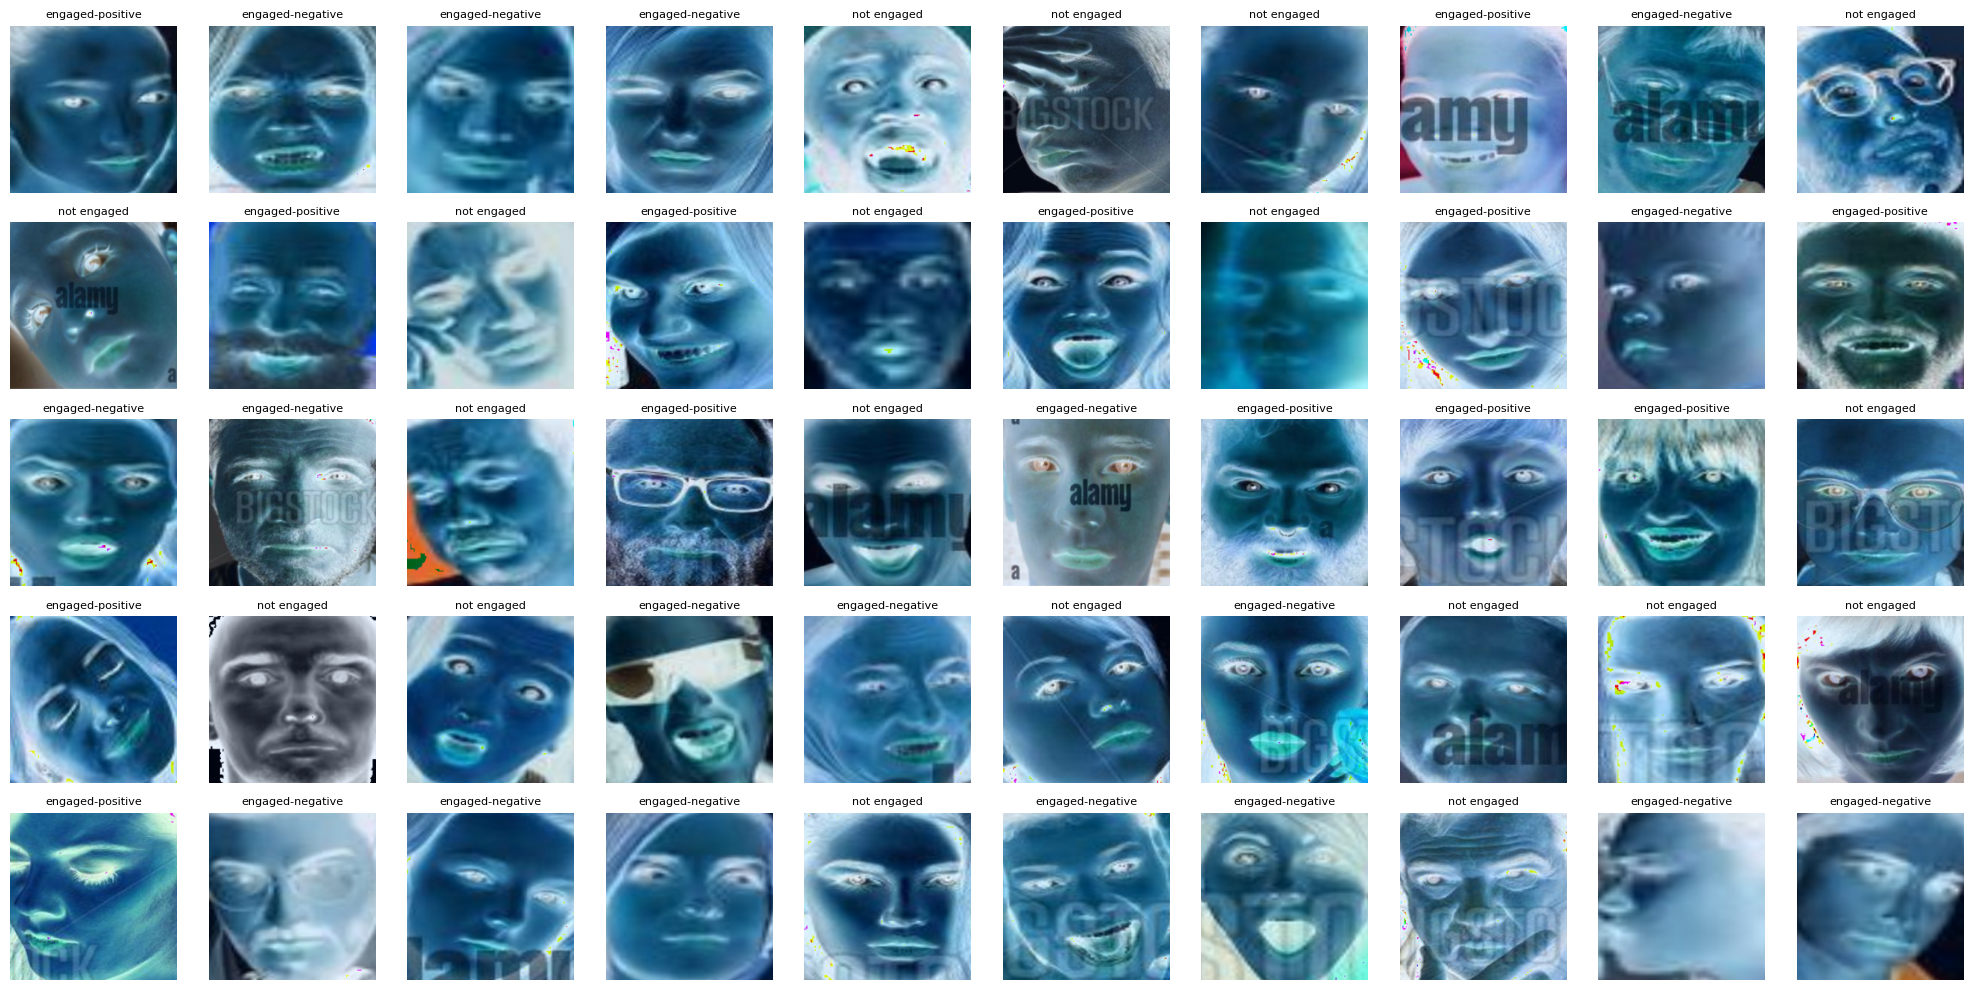

In [11]:
# Printing 50 random pisc ans labels


sample_df = df_balanced.sample(n=50, random_state=42).reset_index(drop=True)

# Step 2: Create plot
plt.figure(figsize=(20, 10))

for i in range(50):
    img_tensor = sample_df.loc[i, 'image']
    label = sample_df.loc[i, 'engagement_type']

    # If normalized, skip this step or apply mean/std unnormalization as needed
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1] for display

    plt.subplot(5, 10, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
''' 

Regularization via dropout is applied

'''


# Step 1: Preprocessing
class EngagementDataset(Dataset):
    def __init__(self, dataframe):
        self.images = list(dataframe['image'].values)
        self.labels = LabelEncoder().fit_transform(dataframe['engagement_type'].values)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if isinstance(image, torch.Tensor):
            image = image.float()
        return image, self.labels[idx]

# Step 2: Simple CNN model
class EmotionNet(nn.Module):
    def __init__(self, num_classes):
        super(EmotionNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Drop 50% of activations during training
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [13]:
# Step 3: Prepare your dataframe
df_balanced = df_balanced[['image', 'engagement_type']]  # Keep only needed columns
train_df, val_df = train_test_split(
    df_balanced,
    test_size=0.15,
    stratify=df_balanced['engagement_type'],
    random_state=42
)

train_dataset = EngagementDataset(train_df)
val_dataset = EngagementDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [14]:
# Step 4: Initialize model, loss, optimizer
num_classes = len(df_balanced['engagement_type'].unique())
model = EmotionNet(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# Step 5: Training loop
for epoch in range(30):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    val_acc = 100. * correct_val / total_val
    print(f"→ Validation Acc: {val_acc:.2f}%")


Epoch 1, Loss: 0.1463, Train Acc: 96.68%
→ Validation Acc: 47.20%
Epoch 2, Loss: 0.1359, Train Acc: 96.91%
→ Validation Acc: 46.78%
Epoch 3, Loss: 0.1216, Train Acc: 97.22%
→ Validation Acc: 46.05%
Epoch 4, Loss: 0.1202, Train Acc: 97.22%
→ Validation Acc: 46.17%
Epoch 5, Loss: 0.1138, Train Acc: 97.09%
→ Validation Acc: 47.38%
Epoch 6, Loss: 0.1038, Train Acc: 97.15%
→ Validation Acc: 46.96%
Epoch 7, Loss: 0.1050, Train Acc: 97.26%
→ Validation Acc: 45.26%
Epoch 8, Loss: 0.0951, Train Acc: 97.22%
→ Validation Acc: 45.99%
Epoch 9, Loss: 0.1028, Train Acc: 97.15%
→ Validation Acc: 45.56%
Epoch 10, Loss: 0.0947, Train Acc: 97.29%
→ Validation Acc: 46.05%
Epoch 11, Loss: 0.0913, Train Acc: 97.36%
→ Validation Acc: 44.65%
Epoch 12, Loss: 0.0963, Train Acc: 97.19%
→ Validation Acc: 46.35%
Epoch 13, Loss: 0.0924, Train Acc: 97.13%
→ Validation Acc: 45.19%
Epoch 14, Loss: 0.0841, Train Acc: 97.40%
→ Validation Acc: 44.10%
Epoch 15, Loss: 0.0857, Train Acc: 97.41%
→ Validation Acc: 46.59%
Epoc

# Visualising predictions to see where the model goes wrong

First try with entire dataset, 10 epocs:
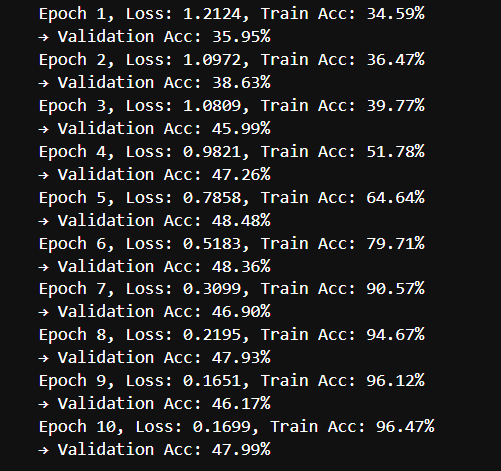

Accuracy from previous training (where engagement categories where groupped instead of labels)

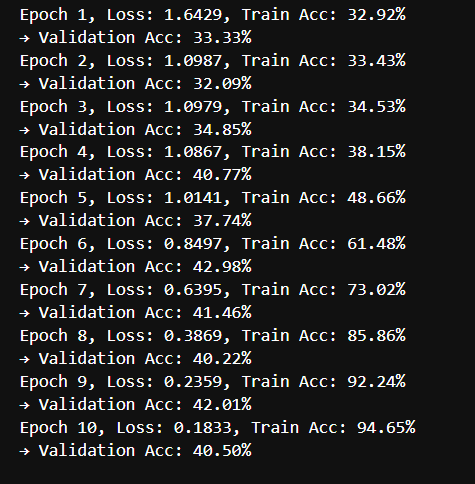

In [16]:
print(model)

EmotionNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [17]:
for name, module in model.named_modules():
    print(name, ":", module)


 : EmotionNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)
features : Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [18]:
df.columns

Index(['name', 'description', 'label', 'base_name', 'emotion_category',
       'image', 'engagement_type'],
      dtype='object')

In [19]:
df[df['engagement_type']=='not engaged']['label'].value_counts()

label
isolation         928
anguish           372
loneliness        352
longing           346
melancholy        307
hopelessness      261
depression        253
defeat            184
gloom             162
neglect           162
dejection         100
sentimentality     93
alienation         66
pity               60
homesickness        6
Name: count, dtype: int64

In [20]:
df[df['engagement_type']=='not engaged']['label'].unique()

array(['longing', 'gloom', 'defeat', 'loneliness', 'alienation',
       'anguish', 'pity', 'sentimentality', 'isolation', 'neglect',
       'hopelessness', 'depression', 'melancholy', 'dejection',
       'homesickness'], dtype=object)

In [21]:
df[df['image']].isna().sum()


KeyboardInterrupt

